In [14]:
#backward difference encoder
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from yellowbrick.regressor import residuals_plot, prediction_error
from fast_ml.model_development import train_valid_test_split
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from tpot import TPOTRegressor
import category_encoders as ce
import time
from xgboost import XGBRegressor
from scipy import stats
import warnings
encoders = {

    'BackwardDifferenceEncoder': ce.backward_difference.BackwardDifferenceEncoder,
    'OneHotEncoder': ce.one_hot.OneHotEncoder,
    
}


In [15]:
test_df = pd.read_csv('./Participants_dataset/test.csv')
roads_df = pd.read_csv('./Participants_dataset/roads_network.csv')
train_df = pd.read_csv('./Participants_dataset/train.csv')

<AxesSubplot:>

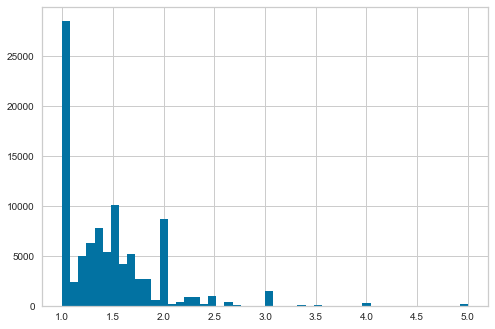

In [16]:
# target
grouped = train_df.groupby('postcode',sort='False',as_index=False)

Accident_Risk_Index_df = grouped.apply(lambda grp: sum(grp.Number_of_Casualties) / len(grp.Accident_ID))
Accident_Risk_Index_df.columns = ['postcode','Accident_Risk_Index']
Accident_Risk_Index_df.Accident_Risk_Index.hist(bins=50)

In [17]:
roads_numeric_features = roads_df.select_dtypes([np.number]).columns
roads_categorical_features = roads_df.select_dtypes(exclude=[np.number]).drop(['WKT','postcode'],axis=1).columns
# overwrite roads df for mem
roads_df = pd.concat([pd.get_dummies(roads_df[roads_categorical_features]),roads_df.drop(roads_categorical_features,axis=1)],axis=1)

In [18]:
roads_features_df = pd.concat([roads_df.drop('WKT',axis=1).groupby('postcode').agg(sum),roads_df.drop('WKT',axis=1).groupby('postcode').agg(np.nanmean)],axis=1)
roads_features_df.columns = [x+'_sum' if i >= 12 else x+'_mean' for i,x in enumerate(roads_features_df.columns)]

In [19]:
train_df = train_df.drop('country',axis=1)
test_df = test_df.drop('country',axis=1)

In [20]:
train_roads_df = train_df.set_index('postcode').join(roads_features_df, how= 'left')
test_roads_df = test_df.set_index('postcode').join(roads_features_df, how= 'left')

In [21]:
print((~train_roads_df.roadClassi_Motorway_mean.isnull()).sum())
inds_where_null = np.where(train_roads_df.roadFuncti_Motorway_sum.isnull())
inds_where_not_null = np.where(train_roads_df.roadFuncti_Motorway_sum.notnull())
# inds where null fill with post town

inds_where_null_test = np.where(test_roads_df.roadFuncti_Motorway_sum.isnull())
inds_where_not_null_test = np.where(test_roads_df.roadFuncti_Motorway_sum.notnull())


28752


In [22]:
roads_features_df['post_town'] = list(pd.Series(roads_features_df.index).str.upper().apply(lambda row_str: row_str.split(' ')[0]))

In [23]:
roads_town_df = roads_features_df.groupby('post_town').agg(np.nanmean)

In [24]:
train_df['post_town'] = train_df.postcode.apply(lambda row_str: row_str.split(' ')[0])
post_code_level_df = train_df.iloc[inds_where_null].set_index('post_town').join(roads_town_df, how='left')
post_town_level_df = train_roads_df.iloc[inds_where_not_null]
train_enriched_df = pd.concat([post_code_level_df, post_town_level_df],axis=0)

test_df['post_town'] = test_df.postcode.apply(lambda row_str: row_str.split(' ')[0])
post_code_level_df_test = test_df.iloc[inds_where_null_test].set_index('post_town').join(roads_town_df, how='left')
post_town_level_df_test = test_roads_df.iloc[inds_where_not_null_test]
test_enriched_df = pd.concat([post_code_level_df_test, post_town_level_df_test],axis=0)


In [25]:
train_enriched_df=train_enriched_df.drop(['Accident_ID'],axis=1)
test_enriched_df=test_enriched_df.drop(['Accident_ID'],axis=1)

In [26]:
train_postcode = train_enriched_df['postcode']
test_postcode = test_enriched_df['postcode']
train_enriched_df = train_enriched_df.drop(['postcode'],axis=1)
test_enriched_df = test_enriched_df.drop(['postcode'],axis=1)

In [27]:
train_enriched_df['month_of_year'] = pd.to_datetime(train_enriched_df.Date).dt.month
train_enriched_df['day_of_month'] = pd.to_datetime(train_enriched_df.Date).dt.day
train_enriched_df = train_enriched_df.drop(['Date'],axis=1)

test_enriched_df['month_of_year'] = pd.to_datetime(test_enriched_df.Date).dt.month
test_enriched_df['day_of_month'] = pd.to_datetime(test_enriched_df.Date).dt.day
test_enriched_df = test_enriched_df.drop(['Date'],axis=1)

In [28]:
train_enriched_df['Time'] = train_enriched_df.Time.fillna('0').astype(str).apply(lambda row: row.replace(':','') ).astype(int)
test_enriched_df['Time'] = test_enriched_df.Time.fillna('0').astype(str).apply(lambda row: row.replace(':','')).astype(int)

In [29]:
cat_cols = []
num_cols = list(train_enriched_df.select_dtypes([np.number]).columns)
for col in train_enriched_df.select_dtypes(exclude=[np.number]).columns:
    if (~train_enriched_df[col].astype(str).apply(lambda row: row.replace('.','').replace('-','').isdigit())).sum() != 0:
        cat_cols.append(col)
    else:
        num_cols.append(col)

In [30]:
cat_cols

['Local_Authority_(Highway)',
 'Road_Type',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'state']

In [31]:
train_enriched_df=train_enriched_df.reset_index().rename({'index':'post_town'},axis=1)
test_enriched_df=test_enriched_df.reset_index().rename({'index':'post_town'},axis=1)

In [32]:
import os 
current_dir = os.getcwd()
os.chdir('..')
from Utils.Metrics import regression as reg_metrics
os.chdir(current_dir)

In [33]:
results_df = pd.DataFrame(columns = ['model','rmse','r2','mape'])

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin


numeric_features = num_cols

categorical_features = cat_cols

max_levels = round(train_enriched_df.columns.shape[0]*0.1)
cats_many = []
cats_few = []
for ft in categorical_features:
    levels = train_enriched_df[ft].unique().shape[0]
    if levels > max_levels:
        cats_many.append(ft)
    else:
        cats_few.append(ft)
        
class group_data_by_postcode(BaseEstimator, TransformerMixin):
    #def __init__(self, post_group):
    #    self.post_group = post_group
    def __init__(self, post_group):
        self.post_group = post_group    
    def fit(self, X, y=None):
        self.groups = groups
        return self
    
    def transform(self, X, y=None):        
        groups = self.groups
        X1 = groups.agg(np.nanmean)
        X2 = groups.agg(np.sum)
        X4 = groups.agg(stats.mode)
        return pd.concat([X1,X2,X3],axis=1)
        
        

X = train_enriched_df
y = Accident_Risk_Index_df.Accident_Risk_Index

y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

selected_model = XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0)


categorical_transformer_many_level = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', encoders['BackwardDifferenceEncoder']())
    ]
)    

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', encoders['OneHotEncoder']())
    ]
) 

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

aggregator = Pipeline(steps=[('groupby_postcode',group_data_by_postcode(train_postcode))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_features),
        ('categorical_many', categorical_transformer_many_level, cats_many),
        ('categorical', categorical_transformer, cats_few)
    ]
)



In [35]:
X_prc = preprocessor.fit_transform(X)
X_prc = pd.DataFrame(X_prc)

In [36]:
X_test_prc = preprocessor.transform(test_enriched_df)
X_test_prc = pd.DataFrame(X_test_prc)

In [37]:
import gc
gc.collect()

53

In [39]:
# groupby on strings just way too slow
def groupby_postcode(X, grouper_var):       
        postcode_to_ind_dct = {x:i for i,x in enumerate(grouper_var)}
        #grouper_var = pd.Series(train_postcode).replace(postcode_to_ind_dct).values
        grouper_var = pd.Series(grouper_var).map(lambda x: postcode_to_ind_dct[x])
        groups = X.groupby(grouper_var,sort='False',as_index=True)
        print('groups created')
        X1 = groups.agg(np.nanmean)
        print('mean grouped')
        X2 = groups.agg(np.sum)
        print('sum grouped')
        X3 = groups.agg('first')
        print('first grouped')
        ind_to_postcode={v:k for k,v in postcode_to_ind_dct.items()}
        return pd.concat([X1,X2,X3],axis=1), [ind_to_postcode[x] for x in X1.index]

X_prc_grp, _ = groupby_postcode(X_prc,list(train_df.postcode))

groups created
mean grouped
sum grouped
first grouped


In [40]:
X_test_prc_grp, inds = groupby_postcode(X_test_prc,list(test_df.postcode))

groups created
mean grouped
sum grouped
first grouped


In [41]:

X_train, X_test_tmp, y_train, y_test_tmp = train_test_split(X_prc_grp, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test_tmp, y_test_tmp, test_size=0.5)
del X_test_tmp, y_test_tmp


In [42]:
# before 'spacifying' parameter ranges, put these into dict for extraction for learning
# before 'spacifying' parameter ranges, put these into dict for extraction for learning
xgb_choice_params = {
    'learning_rate':    np.arange(0.05, 0.31, 0.05),
    'max_depth':        np.arange(5, 16, 1, dtype=int),
    'min_child_weight': np.arange(1, 8, 1, dtype=int),
    'colsample_bytree': np.arange(0.3, 0.8, 0.1),

}

lgb_choice_params = {
    'learning_rate':    np.arange(0.05, 0.31, 0.05),
    'max_depth':        np.arange(5, 16, 1, dtype=int),
    'min_child_weight': np.arange(1, 8, 1, dtype=int),
    'colsample_bytree': np.arange(0.3, 0.8, 0.1),
}

ctb_choice_params = {
    'learning_rate':     np.arange(0.05, 0.31, 0.05),
    'max_depth':         np.arange(5, 16, 1, dtype=int),
    'colsample_bylevel': np.arange(0.3, 0.8, 0.1),

}

In [43]:
from sklearn.metrics import mean_squared_error


# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     200,
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# LightGBM parameters
lgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     100,
}
lgb_fit_params = {
    'eval_metric': 'l2',
    'early_stopping_rounds': 10,
    'verbose': False
}
lgb_para = dict()
lgb_para['reg_params'] = lgb_reg_params
lgb_para['fit_params'] = lgb_fit_params
lgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


# CatBoost parameters
ctb_reg_params = {
    'learning_rate':     hp.choice('learning_rate',     np.arange(0.05, 0.31, 0.05)),
    'max_depth':         hp.choice('max_depth',         np.arange(5, 16, 1, dtype=int)),
    'colsample_bylevel': hp.choice('colsample_bylevel', np.arange(0.3, 0.8, 0.1)),
    'n_estimators':      100,
    'eval_metric':       'RMSE',
}
ctb_fit_params = {
    'early_stopping_rounds': 10,
    'verbose': False
}
ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))


In [44]:
import lightgbm as lgb
import xgboost as xgb
import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}


In [52]:
X_train.columns = list(range(X_train.shape[1]))
X_val.columns = list(range(X_val.shape[1]))
len(set(X_val.columns))

882

In [ ]:
obj = HPOpt(X_train, X_val, y_train, y_val)
# the dataset is not so complex that it needs tones of evals
xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
lgb_opt = obj.process(fn_name='lgb_reg', space=lgb_para, trials=Trials(), algo=tpe.suggest, max_evals=50)
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=50)


 30%|██████████████▋                                  | 15/50 [06:32<16:49, 28.85s/trial, best loss: 1.013644911346869]

In [ ]:
xgb_tuned_params = {x[0]:xgb_choice_params[x[0]][x[1]] if x[0] in xgb_choice_params else x[1] for x in xgb_opt[0].items()}
lgb_tuned_params = {x[0]:lgb_choice_params[x[0]][x[1]] if x[0] in lgb_choice_params else x[1] for x in lgb_opt[0].items()}
ctb_tuned_params = {x[0]:ctb_choice_params[x[0]][x[1]] if x[0] in ctb_choice_params else x[1] for x in ctb_opt[0].items()}

In [ ]:
xgb_reg = XGBRegressor(tree_method = "gpu_hist",single_precision_histogram=True, gpu_id=0, **xgb_tuned_params)
xgb_reg.fit(X_train, y_train, eval_set=[(X_train_prc, y_train), (X_val, y_val)],**xgb_para['fit_params'])
y_pred = xgb_reg.predict(X_test)
pred = y_scaler.inverse_scale(y_pred)
y_val_s = y_scaler.inverse_scale(y_test)
res_row_obj = reg_metrics.calc_results(pred, y_val_s,'Hyperopt XGBReg')
row = res_row_obj.calc_results_row()
results_df = results_df.append(row,ignore_index=True)
results_df

In [ ]:
lgb_reg = lgb.LGBMRegressor(**lgb_tuned_params)
lgb_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],**lgb_para['fit_params'])
y_pred = lgb_reg.predict(X_test)
pred = y_scaler.inverse_scale(y_pred)
y_val_s = y_scaler.inverse_scale(y_test)
res_row_obj = reg_metrics.calc_results(pred, y_val_s,'Hyperopt LGBReg')
row = res_row_obj.calc_results_row()
results_df = results_df.append(row,ignore_index=True)
results_df

In [ ]:
ctb_reg = ctb.CatBoostRegressor(**ctb_tuned_params)
ctb_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],**ctb_para['fit_params'])
y_pred = ctb_reg.predict(X_test)
pred = y_scaler.inverse_scale(y_pred)
y_val_s = y_scaler.inverse_scale(y_test)
res_row_obj = reg_metrics.calc_results(pred, y_val_s,'Hyperopt CTBReg')
row = res_row_obj.calc_results_row()
results_df = results_df.append(row,ignore_index=True)
results_df